# Kaggle challenge: TV-series

### Key points

- use open interactions to filter items as to view an item one must open it first
- must recommend new items with no interactions -> at the end use all the data
- should use completion percentage to assume a implicit ranking for that item

In [42]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from datetime import timedelta
from ast import literal_eval

import random

from sklearn.model_selection import train_test_split
from typing import Optional

In [44]:
from Federico.reader import Reader
reader = Reader()
train_data, test_data = reader.get_train_test_split()
data = reader.process_data(train_data)
# data = data.loc[data.is_valid == 1].copy()
URM_train = reader.data_processor.urm
urm_test = reader.to_urm(test_data)

41629 0 41628
24507 0 24506
1554640


/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team/Federico/reader.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratings'] = 1


In [46]:
test_data = data[data.view_count > 1]
test_data[test_data.is_valid != 1]

,user_id,item_id,view_count,open_count,length,type,is_valid,total_interactions_count,item_avg_view,user_avg_view,item_avg_open,user_avg_open,completion,item_avg_completion,user_avg_completion,view_ratings,open_ratings,completion_ratings,ratings
88,3989,678,2.0,2.0,1.0,3.0,NaN,4.0,8.000000,2.666667,5.000000,2.666667,2.000000,8.000000,2.000000,0.0,0.0,0.0,0.0
197,27157,2677,22.0,56.0,1.0,2.0,NaN,78.0,25.666667,29.666667,61.000000,44.666667,22.000000,25.666667,26.000000,0.0,0.0,0.0,0.0
208,8556,910,18.0,18.0,27.0,4.0,NaN,36.0,12.000000,5.333333,25.333333,4.666667,0.666667,0.444444,3.666667,0.0,0.0,0.0,0.0
414,29415,916,15.0,73.0,3.0,1.0,NaN,88.0,88.333333,9.333333,59.666667,26.000000,5.000000,29.444444,7.666667,0.0,0.0,0.0,0.0
424,20291,1370,2.0,2.0,1.0,3.0,NaN,4.0,1.000000,1.333333,1.000000,1.333333,2.000000,1.000000,1.333333,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320859,33571,2918,67.0,28.0,14.0,4.0,NaN,95.0,48.000000,12.666667,29.666667,29.333333,4.785714,3.428571,6.000000,0.0,0.0,0.0,0.0
1320883,19947,17759,16.0,7.0,1.0,1.0,NaN,23.0,11.000000,12.666667,4.000000,10.666667,16.000000,11.000000,7.166667,0.0,0.0,0.0,0.0
1321005,5635,10269,2.0,7.0,17.0,4.0,NaN,9.0,1.000000,11.333333,1.000000,28.666667,0.117647,0.058824,8.500000,0.0,0.0,0.0,0.0
1321045,7863,2951,27.0,80.0,NaN,NaN,NaN,107.0,53.333333,3.666667,78.000000,20.666667,NaN,NaN,3.666667,0.0,0.0,0.0,0.0


In [47]:
test_data[test_data.item_id == 678]

,user_id,item_id,view_count,open_count,length,type,is_valid,total_interactions_count,item_avg_view,user_avg_view,item_avg_open,user_avg_open,completion,item_avg_completion,user_avg_completion,view_ratings,open_ratings,completion_ratings,ratings
88,3989,678,2.0,2.0,1.0,3.0,NaN,4.0,8.0,2.666667,5.0,2.666667,2.0,8.0,2.000000,0.000000,0.000000,0.000000,0.000000
8799,32093,678,3.0,0.0,1.0,3.0,1.0,3.0,8.0,12.333333,5.0,1.000000,3.0,8.0,8.333333,0.256419,0.000000,0.361500,0.565202
11286,8593,678,2.0,0.0,1.0,3.0,1.0,2.0,8.0,29.000000,5.0,1.000000,2.0,8.0,21.277778,0.087069,0.000000,0.109595,0.521267
23259,22422,678,2.0,1.0,1.0,3.0,1.0,3.0,8.0,10.000000,5.0,22.333333,2.0,8.0,4.666667,0.205000,0.022347,0.410714,0.561795
29638,12147,678,2.0,1.0,1.0,3.0,1.0,3.0,8.0,1.333333,5.0,1.000000,2.0,8.0,1.333333,1.375000,0.037949,1.375000,0.775789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265297,21242,678,2.0,0.0,1.0,3.0,1.0,2.0,8.0,14.666667,5.0,1.000000,2.0,8.0,8.777778,0.147727,0.000000,0.230063,0.539332
1292979,25971,678,2.0,0.0,1.0,3.0,1.0,2.0,8.0,30.666667,5.0,1.000000,2.0,8.0,4.333333,0.083696,0.000000,0.440385,0.545457
1297062,18553,678,3.0,0.0,1.0,3.0,1.0,3.0,8.0,12.333333,5.0,1.000000,3.0,8.0,2.333333,0.256419,0.000000,1.194643,0.625332
1311166,30023,678,2.0,1.0,1.0,3.0,1.0,3.0,8.0,8.333333,5.0,18.333333,2.0,8.0,8.000000,0.241000,0.024103,0.250000,0.555276


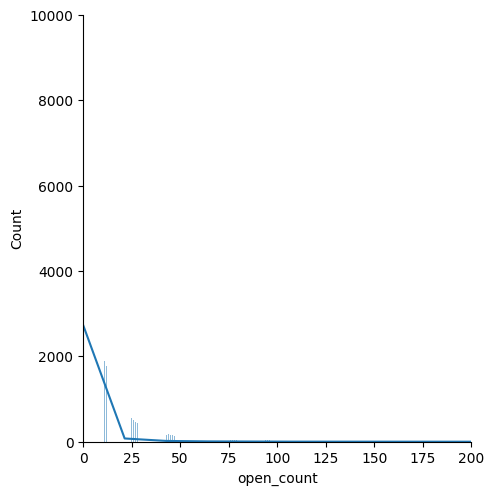

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data=test_data, x='open_count', kde=True)
plt.axis([0, 200, 0, 10000])
plt.show()

### Data cleanup
- we could remove items viewed 1 time and never opened and consider them as noise

In [79]:
from Federico.OpenViewSplitRecommender import OpenViewSplitRecommender

recommender = OpenViewSplitRecommender(
    interactions=data,
    ICM_type=[],
    shape=(reader.num_users, reader.num_items)
)
#recommender.fit(topK=hyperparams.top_k, shrink=hyperparams.shrink)
recommender.fit()

fit: [50, 50, 25, 25]
ItemKNNCFRecommender: URM Detected 65 ( 0.2%) users with no interactions.
Similarity column 24507 (100.0%), 7339.37 column/sec. Elapsed time 3.34 sec
Similarity column 24507 (100.0%), 7107.01 column/sec. Elapsed time 3.45 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 3606.88 column/sec. Elapsed time 6.79 sec


In [75]:
scores = recommender.recommend([1, 2, 3, 4, 5, 6, 10])

pd.DataFrame(scores).T[:10]

,0,1,2,3,4,5,6
0,6874.0,7864.0,20.0,23.0,53.0,270.0,771.0
1,6186.0,10221.0,21.0,21.0,21.0,1068.0,176.0
2,1068.0,22441.0,23.0,124.0,60.0,60.0,177.0
3,393.0,8819.0,393.0,436.0,348.0,598.0,22.0
4,60.0,6712.0,353.0,61.0,25.0,23.0,3397.0
5,61.0,22443.0,25.0,353.0,270.0,61.0,175.0
6,598.0,22631.0,1068.0,56.0,393.0,387.0,613.0
7,270.0,18939.0,58.0,20.0,596.0,521.0,21.0
8,62.0,121.0,396.0,80.0,396.0,393.0,1004.0
9,1748.0,17075.0,269.0,22.0,20.0,1748.0,179.0


In [27]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator = EvaluatorHoldout(urm_test, [5, 10, 20], exclude_seen=True)
results_run_1, results_run_string_1 = evaluator.evaluateRecommender(recommender)

EvaluatorHoldout: Ignoring 916 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 40713 (100.0%) in 2.93 min. Users per second: 231


In [28]:
results_run_1

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.064338,0.073387,0.051473,0.040443,0.045911,0.153711,0.077723,0.057191,0.249404,0.176152,...,0.977996,0.243917,0.977996,0.050107,9.263796,0.992974,0.098527,0.686552,3.991055,0.127911
10,0.048456,0.080558,0.07512,0.024225,0.039707,0.163797,0.078602,0.058912,0.325031,0.197628,...,0.977996,0.317879,0.977996,0.068556,9.656849,0.994902,0.134803,0.715681,3.532653,0.259571
20,0.034639,0.105486,0.104678,0.013754,0.04089,0.168998,0.088592,0.052053,0.399749,0.211915,...,0.977996,0.390953,0.977996,0.094369,10.143485,0.996484,0.18556,0.751747,3.017,0.530393


In [ ]:
10,0.061212,0.083467,0.07227,0.031401,0.042143,0.194669,0.087201,0.066283,0.376606,0.244427,0.004354,0.186239,0.941654,0.994163,0.327376,0.063696,0.997919,0.992938,0.373946,0.992938,0.026482,9.019673,0.994491,0.052156,0.668485,3.673327,0.264678

In [ ]:
10,0.061986,0.084226,0.072906,0.031994,0.042882,0.1973,0.088428,0.067004,0.379848,0.248497,...,0.992938,0.377165,0.992938,0.057082,9.449858,0.994648,0.112421,0.700368,3.617532,0.271728

In [ ]:
# EaseR in views

10,0.063694,0.086838,0.07533,0.032988,0.044328,0.203829,0.091244,0.069025,0.388775,0.256453,0.004349,0.202218,0.933096,0.993307,0.524299,0.059248,0.997919,0.992938,0.386029,0.992938,0.040335,9.056643,0.993635,0.079438,0.671225,3.988502,0.264392

In [ ]:
# Using impressions
10,0.109706,0.119952,0.074853,0.065533,0.070709,0.305609,0.1372,0.088989,0.515234,0.438059,0.00454,0.184028,0.955113,0.995509,0.607418,0.06643,0.998817,0.997358,0.513873,0.997358,0.060017,9.648918,0.996203,0.193102,0.769192,1.746354,0.157587

In [ ]:
# Only views
10,0.055646,0.096959,0.091342,0.028524,0.048405,0.182006,0.092366,0.06916,0.351248,0.225798,0.004366,0.207924,0.936138,0.993611,0.61256,0.051373,0.982128,0.96279,0.338178,0.96279,0.059312,9.367277,0.994073,0.134488,0.710341,3.449254,0.401369

In [80]:
user_id = 800
user_profile_start = urm_test.indptr[user_id]
user_profile_end = urm_test.indptr[user_id + 1]

relevant_items = pd.DataFrame(urm_test.indices[user_profile_start:user_profile_end])
weights = recommender.get_weights(user_id)

relevant_items['is_relevant'] = 1
relevant_items.columns = ['item_id', 'is_relevant']
seen_items = pd.DataFrame(interactions_train[interactions_train['user_id'] == user_id]['item_id'])
seen_items['is_seen'] = 1

weights['is_relevant'] = relevant_items.set_index('item_id')
weights['is_seen'] = seen_items.set_index('item_id')

weights[weights.is_seen != 1]

,item_weights,w_impressions,view_weights,open_weights,user_weights,top_view_score,is_relevant,is_seen
0,0.0,0.0,0.0,0.0,0,0.000606,NaN,NaN
1,0.0,0.0,0.0,0.0,0,0.001544,NaN,NaN
2,0.0,0.0,0.0,0.0,0,0.001268,NaN,NaN
3,0.0,0.0,0.0,0.0,0,0.001599,NaN,NaN
4,0.0,0.0,0.0,0.0,0,0.001875,NaN,NaN
...,...,...,...,...,...,...,...,...
24502,0.0,0.0,0.0,0.0,0,0.000441,NaN,NaN
24503,0.0,0.0,0.0,0.0,0,0.000717,NaN,NaN
24504,0.0,0.0,0.0,0.0,0,0.000551,NaN,NaN
24505,0.0,0.0,0.0,0.0,0,0.000606,NaN,NaN


In [378]:
seen_items = interactions[interactions['user_id'] == 0]['item_id']
np.array(seen_items)

array([   21,   124,   808,  1326,  1995,  5068,  7603,  8540, 10682,
       13290, 14305, 18462,    11,    22,    24,    44,    54,   159,
         239,   575,   751,   987,  1715,  2218,  2256,  2257,  2292,
        2730,  4007,  4047,  4337,  4383,  5336,  5735,  5752,  6351,
        7301,  7499,  8056,  9275,  9374,  9879,  9960, 10013, 10218,
       10261, 11440, 12314, 12562, 12825, 13719, 14826, 16345, 16426,
       16868, 16876, 18194, 20558, 21108, 21586, 21848, 22307, 23170,
       23214, 24264, 24448])

In [329]:
view_recommendations = recommendations[0][:10]
open_recommendations = recommendations[1][:10]

pd.DataFrame([view_recommendations, open_recommendations])

,0,1,2,3,4,5,6,7,8,9
0,22,23,20,353,25,436,56,29,348,58
1,2488,450,448,2494,391,828,9463,1263,299,11250


## Submission

In [19]:
# Get data
from kaggle_challenges.challenge.OpenViewSplitRecommender import OpenViewSplitRecommender

interactions_all = interactions.copy()

data_processor = DataProcessor(data=interactions_all, params=hyperparams, num_users=num_users, num_items=num_items)
data_processor.process_data()
urm_all = data_processor.urm

In [20]:

best_recommender = OpenViewSplitRecommender(
    interactions=data_processor.data,
    ICM_type=icm_type,
    shape=(num_users, num_items)
)

In [21]:
%%time

best_recommender.fit()

fit: [50, 50, 25, 25]
ItemKNNCFRecommender: URM Detected 41629 (100.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 24507 (100.0%) items with no interactions.
Similarity column 24507 (100.0%), 4781.87 column/sec. Elapsed time 5.12 sec
Similarity column 24507 (100.0%), 3848.75 column/sec. Elapsed time 6.37 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1878.28 column/sec. Elapsed time 13.05 sec
CPU times: user 27.4 s, sys: 941 ms, total: 28.4 s
Wall time: 29.1 s


In [22]:
# Build recommendations

def build_recommendations(recommender: OpenViewSplitRecommender):
    target_users = pd.read_csv('data_target_users_test.csv')
    sub_data = pd.DataFrame(target_users, columns=['user_id'])

    sub_data['item_list'] = sub_data.apply(
        lambda row: recommender.recommend(
            user_id_array=row.user_id,
            remove_seen_flag=True
        )[0:10],
        axis=1
    )

    return sub_data

In [23]:
submission = build_recommendations(recommender=best_recommender)

In [24]:
sub_data = submission[['user_id', 'item_list']].copy()
sub_data['item_list'] = sub_data.item_list.apply(
    lambda row: " ".join([str(data) for data in row])
)
sub_data.to_csv("submission.csv", index=None)